<a href="https://colab.research.google.com/github/utkarshg1/Neural-Net-Datasets/blob/main/Time_Series_Forecasting_with_Cross_Val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ARIMA

In [1]:
import pandas as pd
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import Literal
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from statsmodels.tsa.stattools import adfuller


@dataclass
class TimeSeriesData:
    path: str
    date_col: str
    dayfirst: bool
    df: pd.DataFrame = field(init=False, repr=False)

    def __post_init__(self) -> None:
        self.df = pd.read_csv(
            self.path,
            index_col=self.date_col,
            parse_dates=[self.date_col],
            dayfirst= self.dayfirst
        )

    def missing_values(self) -> pd.Series:
        return self.df.isna().sum()

    def plot_observed(self, column: str) -> None:
        self.df[column].plot(
            kind="line",
            ylabel=column,
            title="Observed plot",
            figsize=(12, 6),
            grid=True,
        )
        plt.show()

    def plot_month_seasonal(self, column: str) -> None:
        _, ax = plt.subplots(figsize=(12, 6))
        month_plot(self.df[column].resample("ME").mean(), ax=ax)
        plt.show()

    def plot_quarter_seasonal(self, column: str) -> None:
        _, ax = plt.subplots(figsize=(12, 6))
        quarter_plot(self.df[column].resample("QE").mean(), ax=ax)
        plt.show()

    def decompose(self, column: str, period: int, model: Literal["add", "mul"]) -> None:
        d = seasonal_decompose(self.df[column], model=model, period=period)
        _, axes = plt.subplots(4, 1, figsize=(12, 8))
        d.observed.plot(ax=axes[0], title="Observed")
        d.trend.plot(ax=axes[1], title="Trend")
        d.seasonal.plot(ax=axes[2], title="Seasonal")
        d.resid.plot(ax=axes[3], title="Residual")
        plt.tight_layout()
        plt.show()

    def acf(self, column: str, lags: int) -> None:
        _, ax = plt.subplots(figsize=(12, 6))
        plot_acf(self.df[column], lags=lags, ax=ax)
        plt.show()

    def pacf(self, column: str, lags: int) -> None:
        _, ax = plt.subplots(figsize=(12, 6))
        plot_pacf(self.df[column], lags=lags, ax=ax)
        plt.show()

    def split_train_test(self, column: str, test_size: int):
        train, test = (
            self.df[column].iloc[:-test_size],
            self.df[column].iloc[-test_size:],
        )
        return train, test

    def build_model_and_predict(
        self,
        train: pd.Series,
        test: pd.Series,
        trend: Literal["add", "mul"],
        seasonal: Literal["add", "mul"],
        seasonal_periods: int,
    ):
        model = ExponentialSmoothing(
            train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods
        ).fit()
        preds = model.forecast(len(test))
        return preds

    def model_assesment(self, train, test, preds):
        plt.figure(figsize=(12, 6))
        plt.plot(train, label="Train")
        plt.plot(test, label="Test")
        plt.plot(preds, label="Predicted")
        plt.title("Forecast")
        plt.legend()
        plt.show()
        rmse = root_mean_squared_error(test, preds)
        mae = mean_absolute_error(test, preds)
        mape = mean_absolute_percentage_error(test, preds)
        print(f"Root Mean Squared Error : {rmse:.2f}")
        print(f"Mean Absolute Error : {mae:.2f}")
        print(f"Mean Absolute Percentage Error : {mape:.2%}")

    def test_stationary(self, column: str) -> None:
        result = adfuller(self.df[column])
        print(f"P-value : {result[1]}")
        if result[1] <= 0.05:
            print("Stationary")
        else:
            print("Non-Stationary")

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
%pip install pmdarima

In [4]:
url = "https://raw.githubusercontent.com/utkarshg1/Neural-Net-Datasets/refs/heads/main/daily_revenue.csv"
print(url)

https://raw.githubusercontent.com/utkarshg1/Neural-Net-Datasets/refs/heads/main/daily_revenue.csv


In [5]:
t1 = TimeSeriesData(url, "date", dayfirst=True)
t1

TimeSeriesData(path='https://raw.githubusercontent.com/utkarshg1/Neural-Net-Datasets/refs/heads/main/daily_revenue.csv', date_col='date', dayfirst=True)

In [6]:
t1.df

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%
...,...,...,...
2022-11-26,"26,934,947",30.41%,0.38%
2022-11-27,"31,890,868",29.75%,0.35%
2022-11-28,"32,100,918",25.27%,8.93%


In [7]:
t1.df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [8]:
t1.missing_values()

,0
revenue,0
discount_rate,0
coupon_rate,0


In [9]:
t1.df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq=None)

In [10]:
t1.df = t1.df.asfreq("D")

In [11]:
t1.df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [12]:
def data_cleaning(df):
  for i in df.columns:
    df[i] = df[i].str.replace(",", "")
    df[i] = df[i].str.replace("%", "").astype(float)
  print("Data Cleaning successful")

In [13]:
data_cleaning(t1.df)

Data Cleaning successful


In [14]:
t1.df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27,1.09
2018-01-02,8922076.0,30.87,1.08
2018-01-03,8446101.0,28.11,1.01
2018-01-04,7785798.0,27.32,0.96
2018-01-05,6375303.0,25.70,0.90


In [15]:
t1.df.dtypes

,0
revenue,float64
discount_rate,float64
coupon_rate,float64


In [16]:
column = "revenue"

### EDA

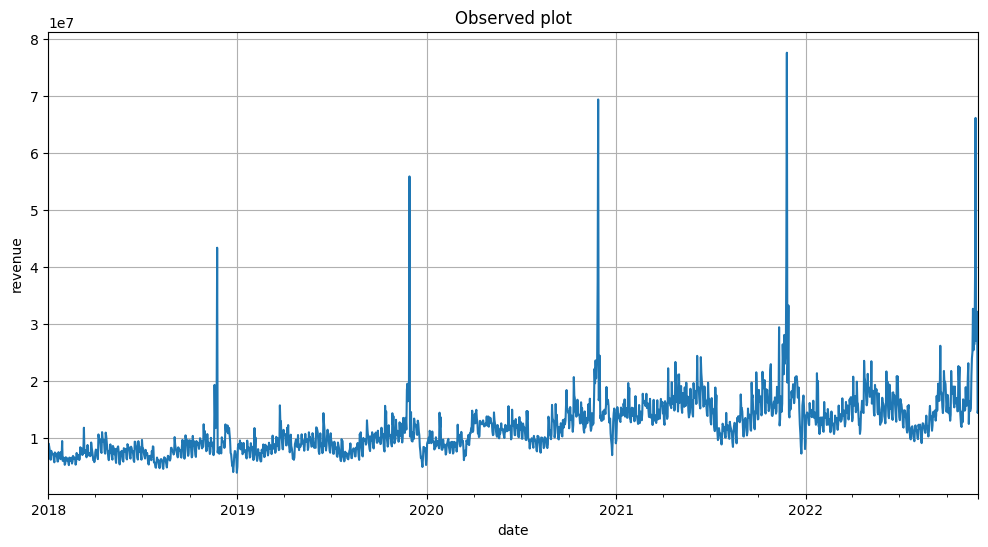

In [17]:
t1.plot_observed(column)

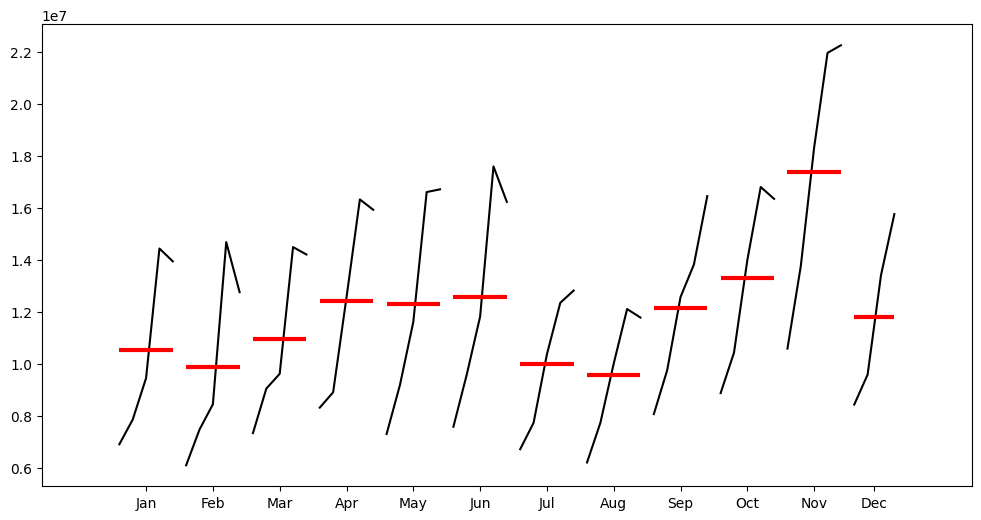

In [18]:
t1.plot_month_seasonal(column)

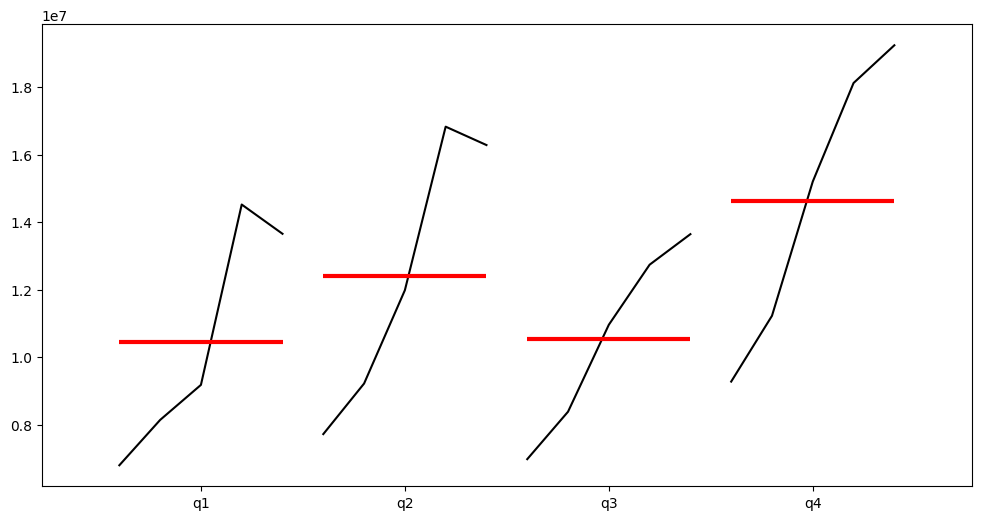

In [19]:
t1.plot_quarter_seasonal(column)

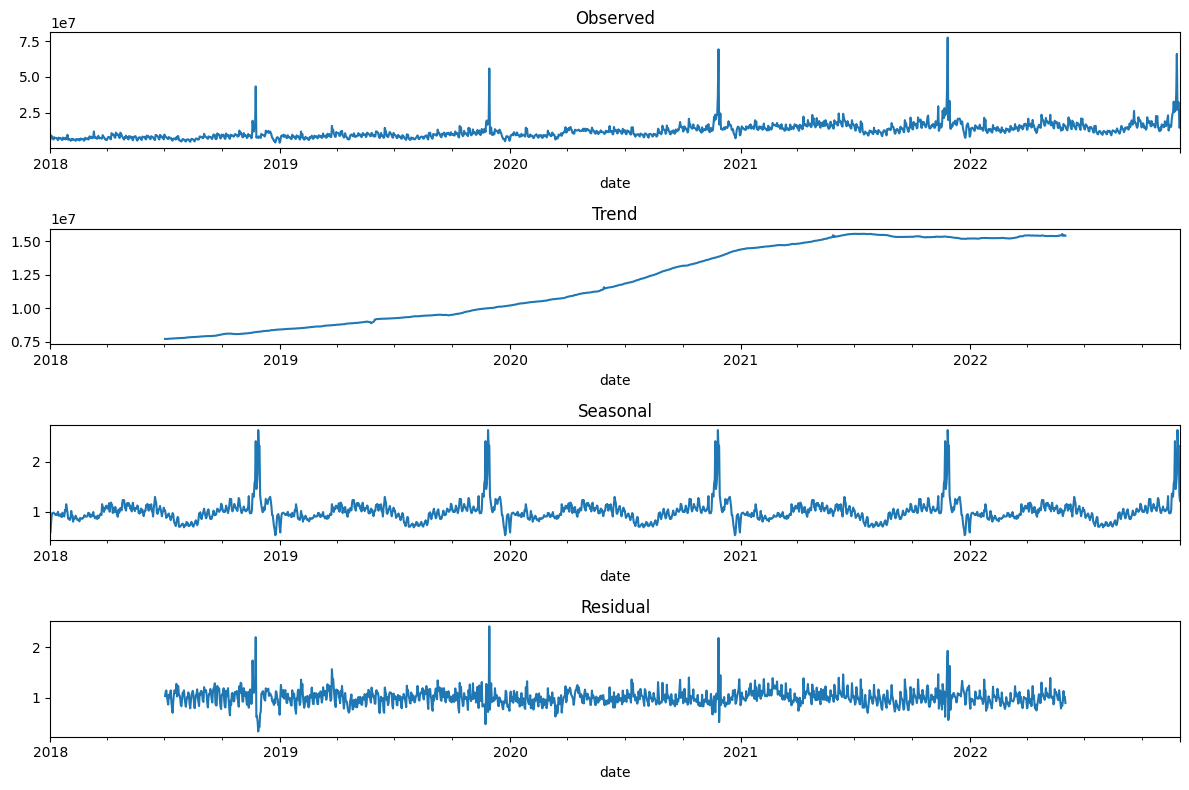

In [20]:
t1.decompose(column, 365, "mul")

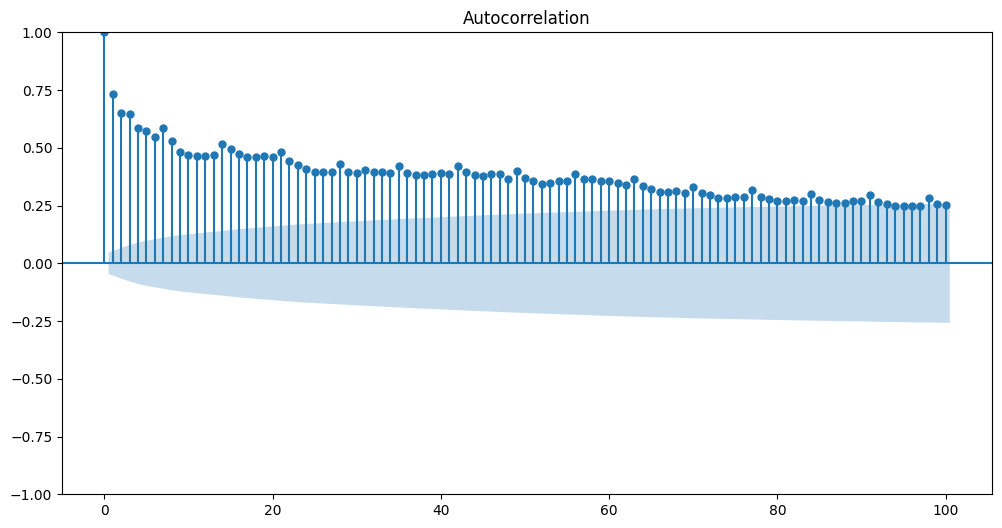

In [21]:
t1.acf(column, 100)

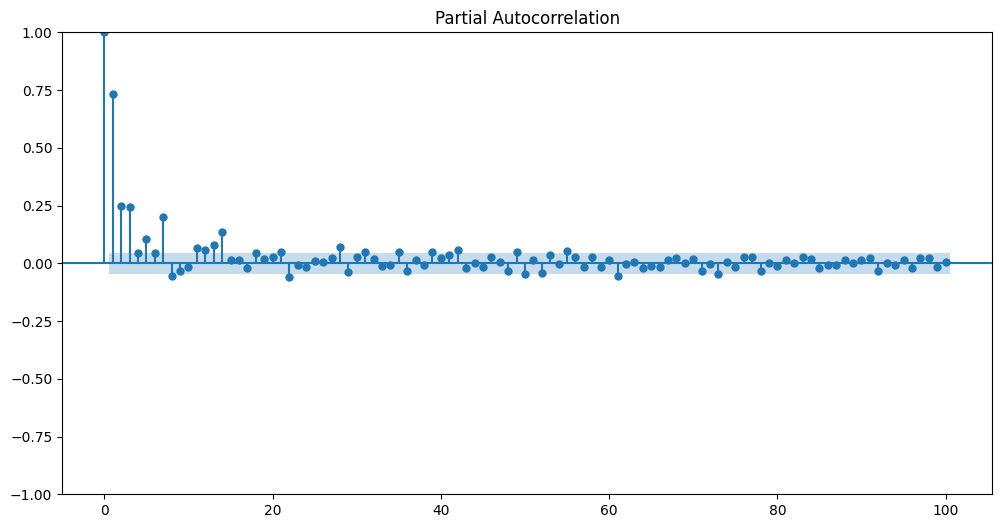

In [22]:
t1.pacf(column, 100)

### Holtwinters Baseline

In [23]:
train, test = t1.split_train_test(column, 30)

In [24]:
train

,revenue
date,
2018-01-01,6270839.0
2018-01-02,8922076.0
2018-01-03,8446101.0
2018-01-04,7785798.0
2018-01-05,6375303.0
...,...
2022-10-27,13714667.0
2022-10-28,12100780.0
2022-10-29,11849363.0


In [25]:
test

,revenue
date,
2022-11-01,16703680.0
2022-11-02,15827022.0
2022-11-03,16154319.0
2022-11-04,14707212.0
2022-11-05,14877530.0
2022-11-06,18835528.0
2022-11-07,16094516.0
2022-11-08,15589508.0
2022-11-09,16608320.0


In [41]:
preds_test = t1.build_model_and_predict(train, test, "add", "mul", seasonal_periods=365)
preds_test

,0
2022-11-01,1.557008e+07
2022-11-02,1.632317e+07
2022-11-03,1.703401e+07
2022-11-04,1.614885e+07
2022-11-05,1.646143e+07
2022-11-06,1.586855e+07
2022-11-07,1.510126e+07
2022-11-08,1.570958e+07
2022-11-09,1.637519e+07
2022-11-10,1.716333e+07


In [42]:
preds_test.astype(int)

,0
2022-11-01,15570082
2022-11-02,16323166
2022-11-03,17034006
2022-11-04,16148848
2022-11-05,16461432
2022-11-06,15868545
2022-11-07,15101260
2022-11-08,15709584
2022-11-09,16375187
2022-11-10,17163327


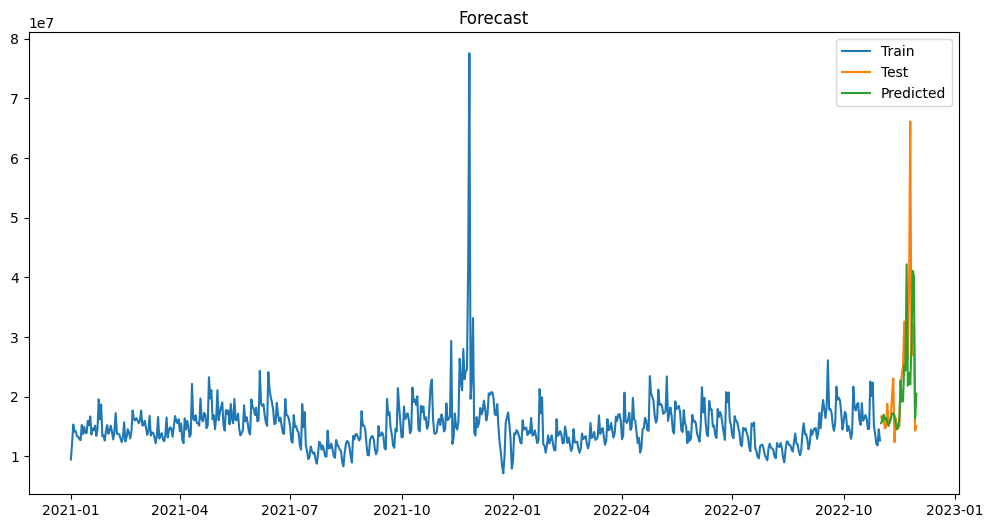

Root Mean Squared Error : 9665244.68
Mean Absolute Error : 5065560.65
Mean Absolute Percentage Error : 17.52%


In [43]:
t1.model_assesment(train.loc["2021":], test, preds_test)

### Baseline model has MAPE of 17.52%

In [29]:
t1.test_stationary(column)

P-value : 0.10190360862386094
Non-Stationary


### ARIMA

In [30]:
train

,revenue
date,
2018-01-01,6270839.0
2018-01-02,8922076.0
2018-01-03,8446101.0
2018-01-04,7785798.0
2018-01-05,6375303.0
...,...
2022-10-27,13714667.0
2022-10-28,12100780.0
2022-10-29,11849363.0


In [31]:
test

,revenue
date,
2022-11-01,16703680.0
2022-11-02,15827022.0
2022-11-03,16154319.0
2022-11-04,14707212.0
2022-11-05,14877530.0
2022-11-06,18835528.0
2022-11-07,16094516.0
2022-11-08,15589508.0
2022-11-09,16608320.0


In [32]:
from pmdarima import auto_arima, ARIMA, model_selection

In [33]:
model = auto_arima(train, seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Thu, 06 Feb 2025   AIC                          57650.535
Time:                        15:20:19   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+42. Standard errors may be unstable.
"""

In [34]:
pred_arima = model.predict(len(test))

In [35]:
pred_arima.astype(int)

,0
2022-11-01,14452994
2022-11-02,14741032
2022-11-03,15032833
2022-11-04,15275199
2022-11-05,15340777
2022-11-06,15534422
2022-11-07,15545421
2022-11-08,15639673
2022-11-09,15650163
2022-11-10,15692207


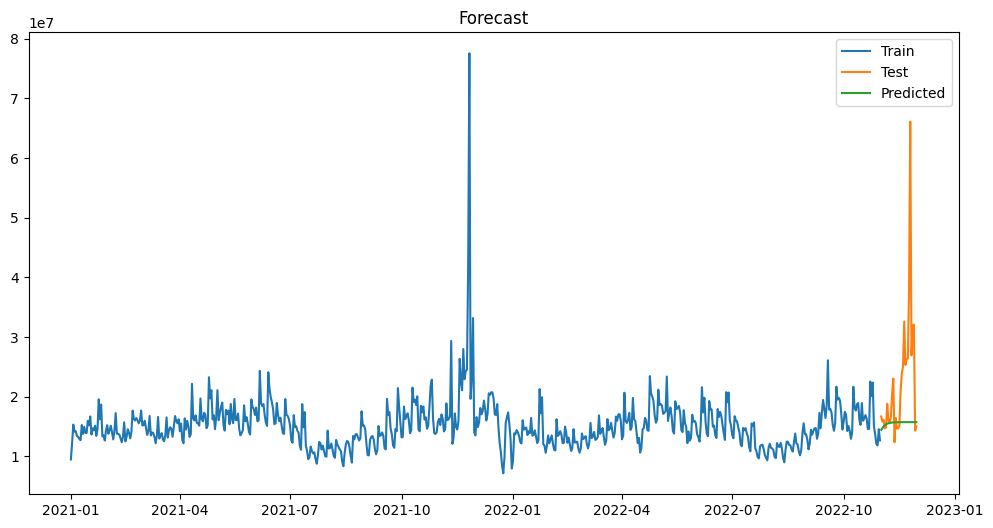

Root Mean Squared Error : 12366038.29
Mean Absolute Error : 7267306.02
Mean Absolute Percentage Error : 24.15%


In [36]:
t1.model_assesment(train.loc["2021":], test, pred_arima)

### SARIMA

In [37]:
model_sarima = auto_arima(train, m=7, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=57566.715, Time=9.19 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=58227.547, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=57935.847, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=57734.264, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=58225.549, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=57640.319, Time=3.07 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=57635.054, Time=3.31 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=57568.136, Time=11.75 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=57568.601, Time=13.40 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=57667.033, Time=2.86 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=57634.563, Time=8.93 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=57627.527, Time=6.74 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=13.27 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=57566.982, Time=5.69 sec
 ARIMA(2,1,1)(1,0,1)[7

In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Thu, 06 Feb 2025   AIC                          57650.535
Time:                        15:25:33   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+42. Standard errors may be unstable.
"""

In [39]:
pred_sarima = model_sarima.predict(len(test))

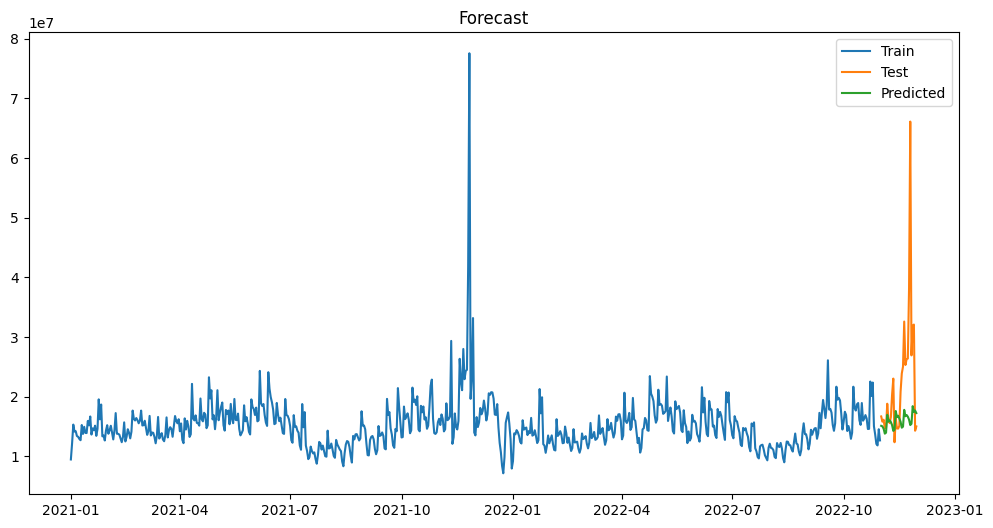

Root Mean Squared Error : 12152429.39
Mean Absolute Error : 7210576.21
Mean Absolute Percentage Error : 24.54%


In [40]:
t1.model_assesment(train.loc["2021":], test, pred_sarima)

### Sarimax

In [44]:
t1.df.columns

Index(['revenue', 'discount_rate', 'coupon_rate'], dtype='object')

In [45]:
train, test = t1.split_train_test(['revenue', 'discount_rate', 'coupon_rate'], 30)

In [46]:
train.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27,1.09
2018-01-02,8922076.0,30.87,1.08
2018-01-03,8446101.0,28.11,1.01
2018-01-04,7785798.0,27.32,0.96
2018-01-05,6375303.0,25.70,0.90


In [47]:
test.head()

,revenue,discount_rate,coupon_rate
date,,,
2022-11-01,16703680.0,23.85,1.50
2022-11-02,15827022.0,20.76,0.94
2022-11-03,16154319.0,21.85,0.92
2022-11-04,14707212.0,20.17,0.88
2022-11-05,14877530.0,17.85,0.41


In [48]:
train_y = train["revenue"]
train_exog = train.iloc[:, 1:]

In [50]:
train_y.head()

,revenue
date,
2018-01-01,6270839.0
2018-01-02,8922076.0
2018-01-03,8446101.0
2018-01-04,7785798.0
2018-01-05,6375303.0


In [52]:
train_exog.head()

,discount_rate,coupon_rate
date,,
2018-01-01,34.27,1.09
2018-01-02,30.87,1.08
2018-01-03,28.11,1.01
2018-01-04,27.32,0.96
2018-01-05,25.70,0.90


In [53]:
test_y = test["revenue"]

In [54]:
test_exog = test.iloc[:, 1:]

In [55]:
test_y.head()

,revenue
date,
2022-11-01,16703680.0
2022-11-02,15827022.0
2022-11-03,16154319.0
2022-11-04,14707212.0
2022-11-05,14877530.0


In [56]:
test_exog.head()

,discount_rate,coupon_rate
date,,
2022-11-01,23.85,1.50
2022-11-02,20.76,0.94
2022-11-03,21.85,0.92
2022-11-04,20.17,0.88
2022-11-05,17.85,0.41


In [57]:
model_sarimax = auto_arima(train_y, exog=train_exog, m=7, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=57566.715, Time=7.84 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=58227.547, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=57935.847, Time=1.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=57734.264, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=58225.549, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=57640.319, Time=3.52 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=57635.054, Time=2.62 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=57568.136, Time=12.39 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=57568.601, Time=12.86 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=57667.033, Time=1.53 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=57634.563, Time=6.28 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=57627.527, Time=8.38 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=14.09 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=57566.982, Time=3.59 sec
 ARIMA(2,1,1)(1,0,1)[7

In [58]:
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Thu, 06 Feb 2025   AIC                          57546.103
Time:                                   15:36:27   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4683.063      2.150      0.032     889.683    1.92e+04
ar.L1         -0.3476      0.072     -4.798      0.000      -0.490      -0.206
ar.L2          0.1856      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8712      0.172      5.071      0.000       0.534       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848628.48
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

In [59]:
preds_sarimax = model_sarimax.predict(len(test_y), exog=test_exog)

In [61]:
preds_sarimax.astype(int)

,0
2022-11-01,15134125
2022-11-02,15045313
2022-11-03,14644558
2022-11-04,13821873
2022-11-05,13980013
2022-11-06,16978400
2022-11-07,15832949
2022-11-08,16051976
2022-11-09,15757879
2022-11-10,15235781


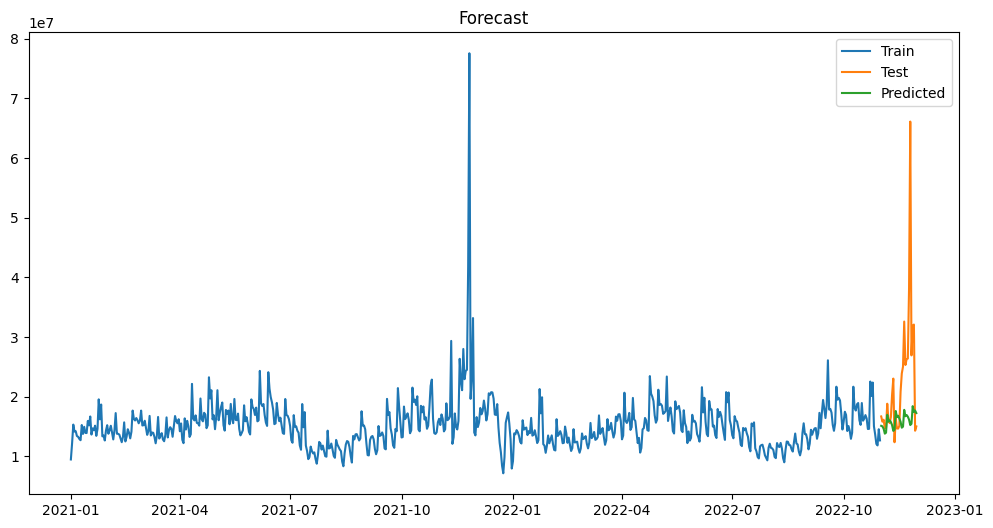

Root Mean Squared Error : 12152429.39
Mean Absolute Error : 7210576.21
Mean Absolute Percentage Error : 24.54%


In [60]:
t1.model_assesment(train_y.loc["2021":], test_y, preds_sarimax)

In [62]:
model_cv = ARIMA(order=(3, 1, 2), seasonal_order=(2, 0, 2, 7))

In [64]:
cv = model_selection.RollingForecastCV(h=30, step=15, initial=t1.df.shape[0]-180)
cv

RollingForecastCV(h=30, initial=1615, step=15)

In [66]:
t1.df

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27,1.09
2018-01-02,8922076.0,30.87,1.08
2018-01-03,8446101.0,28.11,1.01
2018-01-04,7785798.0,27.32,0.96
2018-01-05,6375303.0,25.70,0.90
...,...,...,...
2022-11-26,26934947.0,30.41,0.38
2022-11-27,31890868.0,29.75,0.35
2022-11-28,32100918.0,25.27,8.93


In [68]:
cv_score = model_selection.cross_val_score(model_cv,
                                           y = t1.df["revenue"],
                                           X = t1.df.iloc[:, 1:],
                                           cv=cv,
                                           scoring="mean_squared_error")

In [69]:
cv_score

array([1.15798930e+13, 1.36546325e+13, 1.17759410e+13, 1.17066002e+12,
       8.40114809e+11, 7.20110282e+12, 1.23089645e+13, 5.77957795e+12,
       2.87598806e+13, 1.07212819e+13, 1.09268003e+14])

In [71]:
import numpy as np
rmse_cv = np.sqrt(cv_score).mean()

In [72]:
rmse_cv

3655869.9269685494